## Initialization

In [46]:
import osmnx
import networkx as nx
import polyline
from heapq import heappop, heappush
from itertools import count
from datetime import datetime
import requests

In [47]:
import osmnx
import networkx as nx
import polyline
from heapq import heappop, heappush
from itertools import count
from datetime import datetime
import requests

#### FUNCTIONS ####


def bidirectional_dijkstra(G, source, target, weight="weight"):
    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if source == target:
        return (0, [source])

    weight = _weight_function(G, weight)
    push = heappush
    pop = heappop
    # Init:  [Forward, Backward]
    dists = [{}, {}]  # dictionary of final distances
    paths = [{source: [source]}, {target: [target]}]  # dictionary of paths
    fringe = [[], []]  # heap of (distance, node) for choosing node to expand
    seen = [{source: 0}, {target: 0}]  # dict of distances to seen nodes
    c = count()
    # initialize fringe heap
    push(fringe[0], (0, next(c), source))
    push(fringe[1], (0, next(c), target))
    # neighs for extracting correct neighbor information
    if G.is_directed():
        neighs = [G._succ, G._pred]
    else:
        neighs = [G._adj, G._adj]
    # variables to hold shortest discovered path
    # finaldist = 1e30000
    finalpath = []
    dir = 1
    while fringe[0] and fringe[1]:
        # choose direction
        # dir == 0 is forward direction and dir == 1 is back
        dir = 1 - dir
        # extract closest to expand
        (dist, _, v) = pop(fringe[dir])
        if v in dists[dir]:
            # Shortest path to v has already been found
            continue
        # update distance
        dists[dir][v] = dist  # equal to seen[dir][v]
        if v in dists[1 - dir]:
            # if we have scanned v in both directions we are done
            # we have now discovered the shortest path
            return (finaldist, finalpath)

        for w, d in neighs[dir][v].items():
            # weight(v, w, d) for forward and weight(w, v, d) for back direction
            cost = weight(v, w, d) if dir == 0 else weight(w, v, d)
            if cost is None:
                continue
            vwLength = dists[dir][v] + cost
            if w in dists[dir]:
                if vwLength < dists[dir][w]:
                    raise ValueError(
                        "Contradictory paths found: negative weights?")
            elif w not in seen[dir] or vwLength < seen[dir][w]:
                # relaxing
                seen[dir][w] = vwLength
                push(fringe[dir], (vwLength, next(c), w))
                paths[dir][w] = paths[dir][v] + [w]
                if w in seen[0] and w in seen[1]:
                    # see if this path is better than the already
                    # discovered shortest path
                    totaldist = seen[0][w] + seen[1][w]
                    if finalpath == [] or finaldist > totaldist:
                        finaldist = totaldist
                        revpath = paths[1][w][:]
                        revpath.reverse()
                        finalpath = paths[0][w] + revpath[1:]
    raise nx.NetworkXNoPath(f"No path between {source} and {target}.")


def _weight_function(G, weight):
    if callable(weight):
        return weight
    # If the weight keyword argument is not callable, we assume it is a
    # string representing the edge attribute containing the weight of
    # the edge.
    if G.is_multigraph():
        return lambda u, v, d: min(attr.get(weight, 1) for attr in d.values())
    return lambda u, v, data: data.get(weight, 1)


def api_profile(weather, profile, adjust):

    new_profile = profile

    if adjust:
        now = datetime.now().hour

        if weather not in [202, 212, 221, 502, 503, 504]:
            new_profile.pop("not_flood_hazard")
        if now not in [19, 20, 21, 22, 23, 24, 1, 2, 3, 4, 5]:
            new_profile.pop("lighting")
    else:
        pass
    return new_profile


def adjust_weight(length, row, profile):
    weight = length
    modifier = 1
    for safety_factor, user_preference in profile.items():
        if row[safety_factor] == '0':
            modifier += user_preference
    return weight * modifier

#### PATH FINDING ####

# Returns coordinates of route as an array of tuples


def getCoordinates(route, nodes):
    df = nodes.query('osmid in @route')
    # Drop geometry column
    df = df.drop('geometry', index=None, axis=1)
    coordinates = list(zip(*map(df.get, df)))

    final_coords = []

    for coordinate in coordinates:
        coord = {
            'latitude': coordinate[0],
            'longitude': coordinate[1]
        }
        final_coords.append(coord)

    return final_coords

# Returns encoded polyline using the polyline library, requires input as an array of tuples


def getPolyline(route, nodes):
    coordinates = getCoordinates(route, nodes)
    return polyline.encode(coordinates)

# Function to return the total length of the route in meters


def getRouteLength(route, graph):
    route_length = osmnx.utils_graph.get_route_edge_attributes(
        graph, route, attribute='length')
    return round(sum(route_length))

# Convert bearing value to readable instruction


def getBearingString(degrees, name):
    instruction = None
    if degrees < 45:
        instruction = 'Head North '
    elif degrees < 135:
        instruction = 'Head East '
    elif degrees < 225:
        instruction = 'Head South '
    elif degrees < 315:
        instruction = 'Head West '
    else:
        instruction = 'Head North '
    if name == '':
        return instruction
    return instruction + 'along ' + name

# get maneuever type based on bearing relative_bearing


def getManeuever(heading, true_bearing):
    relative_bearing = abs(true_bearing - heading)
    if relative_bearing <= 15 or relative_bearing >= 345:
        return 'straight'
    return 'turn'

# Translate turn direction in bearings to string


def getTurnDirection(heading, true_bearing, name):
    relative_bearing = true_bearing - heading
    if relative_bearing < 0:
        relative_bearing += 360
    instruction = None
    if relative_bearing <= 15 or relative_bearing >= 345:
        instruction = 'Continue Straight '
    if relative_bearing > 15 and relative_bearing < 45:
        instruction = 'Turn slightly right '
    if relative_bearing >= 45 and relative_bearing < 180:
        instruction = 'Turn Right '
    if relative_bearing > 180 and relative_bearing <= 315:
        instruction = 'Turn Left '
    if relative_bearing > 315 and relative_bearing < 345:
        instruction = 'Turn slightly left '
    if name == '':
        return instruction
    return instruction + 'onto ' + name


def getRouteDirections(route, graph, safety_factors):
    # generate edge bearings for graph
    bearings_graph = osmnx.bearing.add_edge_bearings(graph, precision=1)
    # Generate a dictionary of relevant keys of the route for directions
    steps = osmnx.utils_graph.get_route_edge_attributes(bearings_graph, route)

    direction = []
    instruction = None
    maneuever = None  # depart - first step, turn - for any step in between, arrive - last step
    distance = None
    name = None
    before_maneuever = None
    before_name = None
    footway = None
    bearing_before = 0
    bearing_after = 0
    # Start parsing
    for step in steps:
        present_factors = []
        before_name = name
        before_maneuever = maneuever
        name = step.get("name", "")
        footway = step.get("footway")
        distance = round(step.get("length"))

        for factor in safety_factors:
            if step.get(factor) == '1':
                present_factors.append(factor)

        # If the step is the first step
        if steps[0] == step:
            bearing_before = 0
            bearing_after = step.get("bearing")
            maneuever = 'depart'
            instruction = getBearingString(bearing_after, name)
            direction.append({'maneuever': maneuever,
                              'footway': footway,
                              'instruction': instruction,
                              'name': name,
                              'bearing_before': bearing_before,
                              'bearing_after': bearing_after,
                              'distance': distance,
                              'factors_present': present_factors})
            continue

        # If the step is any steps in between the first and last step
        if steps[0] != step and steps[-1] != step:
            bearing_before = bearing_after
            bearing_after = step.get("bearing")
            maneuever = getManeuever(bearing_before, bearing_after)

            if before_name == name and before_maneuever == maneuever:
                direction[-1]["distance"] += distance
                for factor in present_factors:
                    if factor not in direction[-1]["factors_present"]:
                        direction[-1]["factors_present"].append(factor)
                continue
            if footway == 'crossing':
                instruction = 'Cross the street'
            elif footway == 'footbridge':
                instruction = 'Cross the street via the footbridge'
            else:
                instruction = getTurnDirection(
                    bearing_before, bearing_after, name)
            direction.append({'maneuever': maneuever,
                              'footway': footway,
                              'instruction': instruction,
                              'name': name,
                              'bearing_before': bearing_before,
                              'bearing_after': bearing_after,
                              'distance': distance,
                              'factors_present': present_factors})
            continue

        # If the step is the last step
        if steps[-1] == step:
            bearing_before = bearing_after
            bearing_after = step.get("bearing")
            maneuever = 'arrive'
            instruction = getTurnDirection(
                bearing_before, bearing_after, name) + " and arrive at destination"
            direction.append({'maneuever': maneuever,
                              'footway': footway,
                              'instruction': instruction,
                              'name': name,
                              'bearing_before': bearing_before,
                              'bearing_after': bearing_after,
                              'distance': distance,
                              'factors_present': present_factors})

    return direction



def pathfinder(source, goal, adjust):

    #### SETTINGS ####

    safety_factors = ['not_flood_hazard', 'pwd_friendly',
                      'cctv', 'landmark', 'lighting', 'not_major_road']
    osmnx.settings.useful_tags_way = safety_factors + ['name', 'footway']

    # TODO: insert function to adjust profile weights depending on user preference\

    profile = {"not_flood_hazard": 0.5,
               "pwd_friendly": 0.5,
               "cctv": 0.5,
               "landmark": 0.5,
               "lighting": 0.5,
               "not_major_road": 0.5}

    # comes from application request
    origin = {
        "y": source[0],  # 14.635749969867808,
        "x": source[1]  # 121.09445094913893
    }
    destination = {
        "y": goal[0],  # 14.63056033942939,
        "x": goal[1]  # 121.09807731641334
    }

    params = {
        'lat': source[0],
        'long': source[1],
        'API_key': '998183354bb6d9e4f0bf9a1ce02a8014'
    }

    api_result = requests.get(
        f'https://api.openweathermap.org/data/2.5/weather?lat={params["lat"]}&lon={params["long"]}&appid={params["API_key"]}')

    api_response = api_result.json()

    weather_condition = api_response['weather'][0]['id']

    # retrieve map from database
    graph = osmnx.graph_from_xml('marikina_complete.osm', simplify=False)

    # get all edges for weight adjustment
    nodes, edges = osmnx.graph_to_gdfs(graph)

    # adjust weights profile depending on user pref and time & weather conditions
    adjusted_profile = api_profile(weather_condition, profile, adjust)

    # create category "weight" for use in path finding
    edges['weight'] = edges.apply(
        lambda row: adjust_weight(row['length'], row, adjusted_profile), axis=1
    )

    final_graph = osmnx.graph_from_gdfs(
        osmnx.graph_to_gdfs(graph, edges=False),
        edges
    )

    origin_node_id = osmnx.nearest_nodes(final_graph, origin['x'], origin['y'])
    destination_node_id = osmnx.nearest_nodes(
        final_graph, destination['x'], destination['y'])

    route = bidirectional_dijkstra(
        final_graph,
        origin_node_id,
        destination_node_id,
        weight='weight'
    )

    route = route[1]

    response = {
        'origin': [origin['y'], origin['x']],
        'destination': [destination['y'], destination['x']],
        'length': getRouteLength(route, graph),
        'polyline': getPolyline(route, nodes),
        'steps': getRouteDirections(route, graph, list(adjusted_profile.keys()))
    }

    return response


## PathFinder .py step-by-step

In [48]:
safety_factors = ['not_flood_hazard', 'pwd_friendly',
                      'cctv', 'landmark', 'lighting', 'not_major_road']
osmnx.settings.useful_tags_way = safety_factors + ['name', 'footway']

In [49]:
profile = {"not_flood_hazard": 0.4,
            "pwd_friendly": 0,
            "cctv": 0.2,
            "landmark": 1,
            "lighting": 0.6,
            "not_major_road": 0.2}

In [50]:
coordinates = [14.630879919500508, 121.08234979283692, 14.633050516575146, 121.09895970916124]

In [51]:
# comes from application request
origin = {
    "y": coordinates[0],  # 14.635749969867808,
    "x": coordinates[1]  # 121.09445094913893
}
destination = {
    "y": coordinates[2],  # 14.63056033942939,
    "x": coordinates[3]  # 121.09807731641334
}

In [52]:
params = {
    'lat': coordinates[0],
    'long': coordinates[1],
    'API_key': '998183354bb6d9e4f0bf9a1ce02a8014'
}

api_result = requests.get(
    f'https://api.openweathermap.org/data/2.5/weather?lat={params["lat"]}&lon={params["long"]}&appid={params["API_key"]}')

api_response = api_result.json()

weather_condition = api_response['weather'][0]['id']

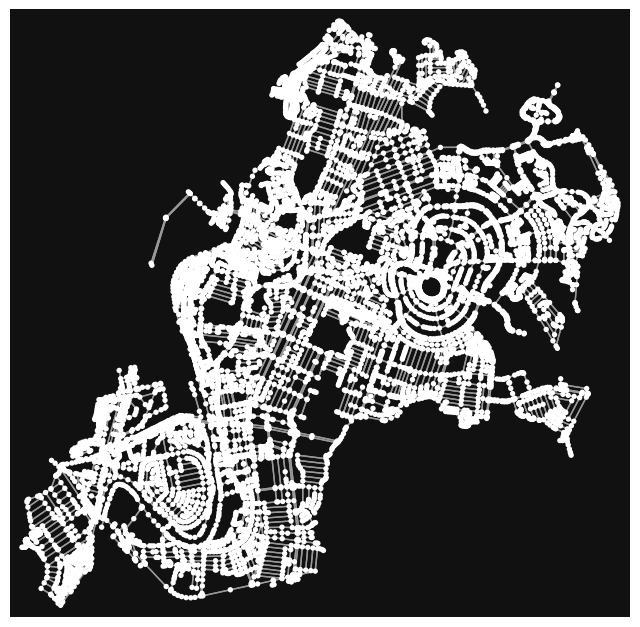

In [53]:
graph = osmnx.graph_from_xml('marikina_complete.osm', simplify=False)
fig, ax = osmnx.plot_graph(graph)

In [54]:
nodes, edges = osmnx.graph_to_gdfs(graph)

In [55]:
nodes

,y,x,geometry
osmid,,,
-164272,14.654481,121.129003,POINT (121.12900 14.65448)
-164273,14.654153,121.129035,POINT (121.12903 14.65415)
-164274,14.662394,121.109061,POINT (121.10906 14.66239)
-164275,14.663969,121.109776,POINT (121.10978 14.66397)
-164276,14.664420,121.109975,POINT (121.10998 14.66442)
...,...,...,...
-187699,14.629581,121.101778,POINT (121.10178 14.62958)
-187701,14.629806,121.101634,POINT (121.10163 14.62981)
-188698,14.664392,121.106569,POINT (121.10657 14.66439)


In [56]:
type(nodes.iloc[0].x)

numpy.float64

In [57]:
nodes.index

Int64Index([-164272, -164273, -164274, -164275, -164276, -164277, -164278,
            -164279, -164280, -164281,
            ...
            -175824, -175825, -187646, -187691, -187698, -187699, -187701,
            -188698, -189622, -189847],
           dtype='int64', name='osmid', length=11382)

In [58]:
adjusted_profile = api_profile(weather_condition, profile, adjust=True)

In [59]:
list(adjusted_profile.keys())

['pwd_friendly', 'cctv', 'landmark', 'lighting', 'not_major_road']

In [60]:
safety_factors

['not_flood_hazard',
 'pwd_friendly',
 'cctv',
 'landmark',
 'lighting',
 'not_major_road']

In [61]:
edges['weight'] = edges.apply(
        lambda row: adjust_weight(row['length'], row, adjusted_profile), axis = 1
        )

In [62]:
final_graph = osmnx.graph_from_gdfs(
        osmnx.graph_to_gdfs(graph, edges=False),
        edges
    )

In [63]:
origin_node_id = osmnx.nearest_nodes(final_graph, origin['x'], origin['y'], return_dist=True)
destination_node_id = osmnx.nearest_nodes(final_graph, destination['x'], destination['y'], return_dist=True)

In [64]:
route = bidirectional_dijkstra(
    final_graph, 
    origin_node_id[0], 
    destination_node_id[0], 
    weight='weight'
    )

In [65]:
# generate edge bearings for graph
bearings_graph = osmnx.bearing.add_edge_bearings(graph, precision=1)

In [66]:
route

(4699.120199999999,
 [-171747,
  -172286,
  -169534,
  -170072,
  -169486,
  -169464,
  -169697,
  -173925,
  -173430,
  -172850,
  -170637,
  -173938,
  -173837,
  -173429,
  -170707,
  -174781,
  -172318,
  -169476,
  -170061,
  -170950,
  -172275,
  -168895,
  -171106,
  -174881,
  -171694,
  -171240,
  -173894,
  -170525,
  -172737,
  -173318,
  -169917,
  -175520,
  -172149,
  -174347,
  -174933,
  -169935,
  -173705,
  -173768,
  -171033,
  -168768,
  -169351,
  -172897,
  -175096,
  -171916,
  -175679,
  -170683,
  -174510,
  -169512,
  -170098,
  -168673,
  -172512,
  -174708,
  -175295,
  -170298,
  -171299,
  -173504,
  -174082,
  -169084,
  -172926,
  -172547,
  -175125,
  -175708,
  -169681,
  -173859,
  -174439,
  -171905,
  -174305,
  -171543,
  -170322,
  -174149,
  -171419,
  -173622,
  -170247,
  -172461,
  -173045,
  -175244,
  -171874,
  -174076,
  -174658,
  -169658,
  -173498,
  -175702,
  -175024,
  -173535,
  -171331,
  -170860,
  -174836,
  -171259,
  -169045,
 

In [67]:
# Generate a dictionary of relevant keys of the route for directions
steps = osmnx.utils_graph.get_route_edge_attributes(bearings_graph, route[1])

In [68]:
steps

[{'osmid': -115873,
  'not_flood_hazard': '0',
  'pwd_friendly': '0',
  'cctv': '0',
  'landmark': '1',
  'lighting': '1',
  'not_major_road': '1',
  'footway': 'sidewalk',
  'oneway': False,
  'reversed': True,
  'length': 33.431,
  'bearing': 14.6},
 {'osmid': -115873,
  'not_flood_hazard': '0',
  'pwd_friendly': '0',
  'cctv': '0',
  'landmark': '1',
  'lighting': '1',
  'not_major_road': '1',
  'footway': 'sidewalk',
  'oneway': False,
  'reversed': True,
  'length': 38.791,
  'bearing': 13.7},
 {'osmid': -115873,
  'not_flood_hazard': '0',
  'pwd_friendly': '0',
  'cctv': '0',
  'landmark': '1',
  'lighting': '1',
  'not_major_road': '1',
  'footway': 'sidewalk',
  'oneway': False,
  'reversed': True,
  'length': 57.156,
  'bearing': 12.9},
 {'osmid': -115873,
  'not_flood_hazard': '0',
  'pwd_friendly': '0',
  'cctv': '0',
  'landmark': '1',
  'lighting': '1',
  'not_major_road': '1',
  'footway': 'sidewalk',
  'oneway': False,
  'reversed': True,
  'length': 3.947,
  'bearing': 

In [75]:
id = steps[0]['osmid']

In [76]:
nodes

,y,x,geometry
osmid,,,
-164272,14.654481,121.129003,POINT (121.12900 14.65448)
-164273,14.654153,121.129035,POINT (121.12903 14.65415)
-164274,14.662394,121.109061,POINT (121.10906 14.66239)
-164275,14.663969,121.109776,POINT (121.10978 14.66397)
-164276,14.664420,121.109975,POINT (121.10998 14.66442)
...,...,...,...
-187699,14.629581,121.101778,POINT (121.10178 14.62958)
-187701,14.629806,121.101634,POINT (121.10163 14.62981)
-188698,14.664392,121.106569,POINT (121.10657 14.66439)


In [77]:
nodes.filter(items=[id], axis=0).y.item()

Series([], Name: y, dtype: float64)